In [1]:
import torch

# get index of currently selected device
torch.cuda.current_device() # returns 0 in my case


# get number of GPUs available
torch.cuda.device_count() # returns 1 in my case


# get the name of the device
torch.cuda.get_device_name(0) # good old Tesla K80


'NVIDIA GeForce RTX 4070 SUPER'

Package Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import matplotlib.pyplot as plt

Setting the seeds (Not random)

In [2]:
torch.manual_seed(0)
cudnn.benchmark = True  # May train faster but cost a bit more memory
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# Provide data directory
data_dir = os.getcwd()
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
                for x in ['train', 'test']}

In [6]:
def imshow(inp, title=None):

    # use transpose to get the image into the right format
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

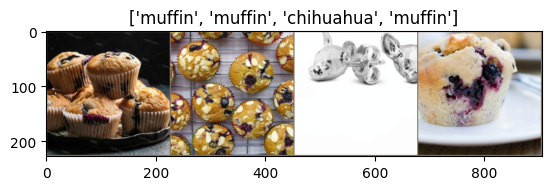

In [7]:
# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

# plot the grid with a title that shows the classes
imshow(out, title=[class_names[x] for x in classes])

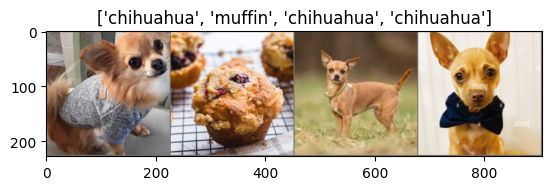

In [8]:
# get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

# plot the grid with a title that shows the classes
imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=8):

    since = time.time()

    # create a deep copy of the model provided
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# Load a pretrained ResNet-18 model from torchvision.models with weights trained on ImageNet.
# If you want to use a different model, e.g., models.vgg16, replace 'resnet18' with the desired model name.
model_ft = models.resnet18(pretrained=True)

# Get the number of input features for the final fully connected (fc) layer.
# For other models, the attribute name for the classifier may differ (e.g., vgg16 uses model.classifier[6].in_features).
num_ftrs = model_ft.fc.in_features

# Replace the final fc layer with a new Linear layer that outputs the number of classes in your dataset.
# For other models, you may need to replace a different layer (e.g., model.classifier[6] for VGG).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the selected device (GPU or CPU).
model_ft = model_ft.to(device)

# Define the loss function as CrossEntropyLoss, suitable for multi-class classification.
# For regression tasks, you might use nn.MSELoss or another appropriate loss.
criterion = nn.CrossEntropyLoss()

# Set up the optimizer as SGD with learning rate 0.001 and momentum 0.9.
# You can use other optimizers like Adam (optim.Adam) or RMSprop depending on your needs.
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Set up a learning rate scheduler that decays the LR by a factor of 0.1 every 7 epochs.
# Other schedulers are available, such as ReduceLROnPlateau or CosineAnnealingLR.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate the model using the train_model function defined earlier.
# You can adjust num_epochs or use a different training loop if needed.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=8)

c:\Users\USER\miniconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\miniconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


Epoch 0/7
----------
train Loss: 0.3560 Acc: 0.8648
test Loss: 0.0369 Acc: 0.9865

Epoch 1/7
----------
train Loss: 0.3710 Acc: 0.8694
test Loss: 0.0314 Acc: 0.9856

Epoch 2/7
----------
train Loss: 0.2127 Acc: 0.9197
test Loss: 0.0223 Acc: 0.9916

Epoch 3/7
----------
train Loss: 0.1677 Acc: 0.9360
test Loss: 0.0611 Acc: 0.9806

Epoch 4/7
----------
train Loss: 0.1065 Acc: 0.9571
test Loss: 0.0256 Acc: 0.9916

Epoch 5/7
----------
train Loss: 0.1015 Acc: 0.9596
test Loss: 0.0260 Acc: 0.9924

Epoch 6/7
----------
train Loss: 0.0837 Acc: 0.9700
test Loss: 0.0395 Acc: 0.9865

Epoch 7/7
----------
train Loss: 0.0628 Acc: 0.9774
test Loss: 0.0177 Acc: 0.9941

Training complete in 6m 55s
Best test Acc: 0.994088


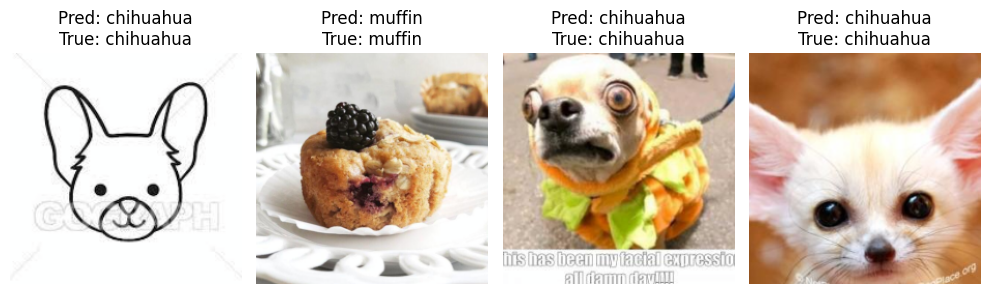

In [18]:
# Get a batch of test data
inputs, classes = next(iter(dataloaders['test']))

# Move inputs to the correct device
inputs = inputs.to(device)

# Set model to evaluation mode and get predictions
model_ft.eval()
with torch.no_grad():
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

# Move inputs and predictions to CPU for visualization
inputs_cpu = inputs.cpu()
preds_cpu = preds.cpu()

# Show images with predicted and true labels
plt.figure(figsize=(10, 6))
for i in range(inputs_cpu.size(0)):
    ax = plt.subplot(1, inputs_cpu.size(0), i + 1)
    inp = inputs_cpu[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    ax.set_title(f"Pred: {class_names[preds_cpu[i]]}\nTrue: {class_names[classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

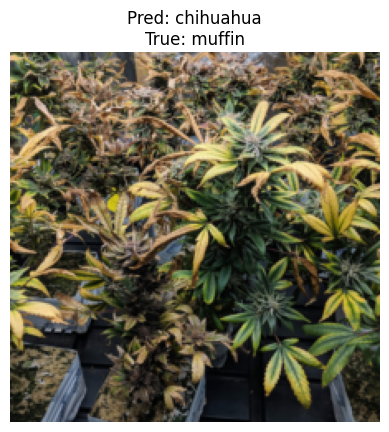

In [25]:
all_preds = []
all_labels = []
all_imgs = []

model_ft.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels)
        all_imgs.append(inputs.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_imgs = torch.cat(all_imgs)

# Find wrong predictions
wrong_indices = (all_preds != all_labels).nonzero(as_tuple=True)[0]

if len(wrong_indices) > 0:
    idx = wrong_indices[0].item()
    img = all_imgs[idx].numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[all_preds[idx]]}\nTrue: {class_names[all_labels[idx]]}")
    plt.axis('off')
    plt.show()
else:
    print("No wrong predictions in the test set.")

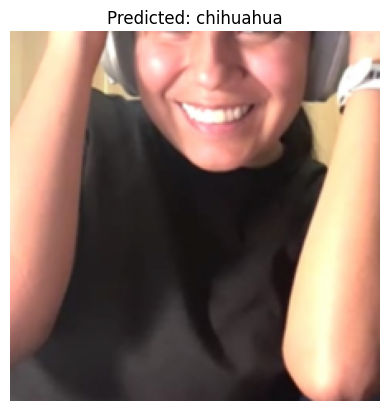

In [30]:
from PIL import Image

# Path to your new image
img_path = 'PuchiPic.jpg'

# Load and preprocess the image
img_pil = Image.open(img_path).convert('RGB')
img_tensor = data_transforms['test'](img_pil).unsqueeze(0).to(device)

# Model inference
model_ft.eval()
with torch.no_grad():
    output = model_ft(img_tensor)
    _, pred = torch.max(output, 1)

# Show the image and prediction
img_np = img_tensor.cpu().squeeze().numpy().transpose((1, 2, 0))
img_np = std * img_np + mean
img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.title(f"Predicted: {class_names[pred.item()]}")
plt.axis('off')
plt.show()

In [31]:
# Save the model's state_dict (recommended)
torch.save(model_ft.state_dict(), 'resnet18_chihuahua_muffin.pth')

# To load it elsewhere:
# model = models.resnet18()
# model.fc = nn.Linear(num_ftrs, len(class_names))
# model.load_state_dict(torch.load('resnet18_chihuahua_muffin.pth'))
# model.eval()